In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lets start by defining any function, using mathematical terms to better understand the underlyings
def f(x):
    return x**2 - 4*x 

# Execute our function for any value 
f(3)

-3

In [3]:
# We define our x array using arange
# Will go from [-5 to 5) in intervals of .25
xs = np.arange(-5, 5, 0.25)

# We can pass the array to our function to get our set of ys
ys = f(xs)

print(f"xs: {xs} \n")
print(f"ys: {ys}")

xs: [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75] 

ys: [45.     41.5625 38.25   35.0625 32.     29.0625 26.25   23.5625 21.
 18.5625 16.25   14.0625 12.     10.0625  8.25    6.5625  5.      3.5625
  2.25    1.0625  0.     -0.9375 -1.75   -2.4375 -3.     -3.4375 -3.75
 -3.9375 -4.     -3.9375 -3.75   -3.4375 -3.     -2.4375 -1.75   -0.9375
  0.      1.0625  2.25    3.5625]


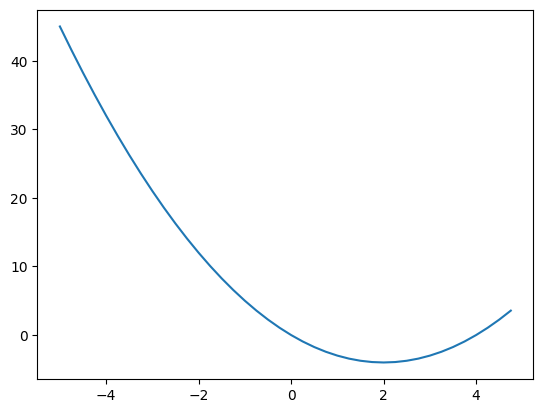

In [4]:
# Lets plot the function
plt.plot(xs, ys)

Lets introduce the concept of derivate:


$$\frac{d}{dx} f(x) = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$


- x is the input value
- h is an infinitesimally small change in x (approaching zero)

The derivative represents the rate of change of the function at a given point, which can be thought of as the "instantaneous" speed at which the output changes when the input changes.

In simple terms, we increment the input x $f(x + h)$, then we compare it with the actual value $- f(x)$ and finally we normalice the change $/h$

In [5]:
# Lets compute the derivative of our function using the formula
h = 0.0000001 # Remember it tends to 0
x = 2/3
(f(x+h)-f(x))/h

-2.666666563122533

In [6]:
# We will declare a Value class, which will help us in the future determine which value changed
# the other value that made it change, and the operator of the change
class Value:
    def __init__(self, data, children=(), operator="", label = "") -> None:
        self.data = data
        self._prev = set(children)
        self._op = operator
        self.grad = 0.0
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    # Helper to ensure operands are of Value type
    def _ensure_value(self, other):
        return other if isinstance(other, Value) else Value(other)
    
    # Addition
    def __add__(self, other):
        other = self._ensure_value(other)
        return Value(self.data + other.data, children=(self, other), operator='+')

    def __radd__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return self + other

    # Subtraction
    def __sub__(self, other):
        other = self._ensure_value(other)
        return Value(self.data - other.data, children=(self, other), operator='-')

    def __rsub__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return Value(other) - self
    
    # Multiplication
    def __mul__(self, other):
        other = self._ensure_value(other)
        return Value(self.data * other.data, children=(self, other), operator='*')

    def __rmul__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return self * other

    # Division
    def __truediv__(self, other):
        other = self._ensure_value(other)
        if other.data == 0:
            raise ZeroDivisionError("Cannot divide by zero")
        return Value(self.data / other.data, children=(self, other), operator='/')

    def __rtruediv__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return Value(other) / self

    # Exponentiation
    def __pow__(self, other):
        other = self._ensure_value(other)
        return Value(self.data ** other.data, children=(self, other), operator='**')

    def __rpow__(self, other):
        # This is called when Value is on the right and int/float is on the left
        return Value(other) ** self
    
    # Hyperbolic Tangent (Tanh)
    def tanh(self):
        return Value((math.exp(self.data) - math.exp(-self.data)) / (math.exp(self.data) + math.exp(-self.data)), children=(self,), operator='tanh')



    
a = Value(2.0)
b = Value(-3.0)
a*b - a/b**2

Value(data=-6.222222222222222)

In [7]:
# Lets create a helper function for derivatives
def compute_derivative(x):
    h = Value(0.0000001)
    return (f(x+h) - f(x))/h

val = Value(-2.0)
compute_derivative(val)

Value(data=-7.999999898089527)

The 'gradient' is a multivariable generalization of the derivative. While a derivative can be defined only for single-variable functions, for functions of multiple variables, the gradient takes its place. The gradient is a vector-valued function, unlike a derivative, which is a scalar-valued function.

For example, if we have a function `f(x,y)` that depends on two variables `x` and `y`, the gradient would be:

$$\nabla f(x,y) = \left[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right] 

 = \left[\frac{\partial f(x,y)}{\partial x}, \frac{\partial f(x,y)}{\partial y}\right]$$



The 'chain rule' is a formula that expresses the derivative of the composition of two differentiable functions.

$$\frac{dz}{dx} = \frac{dz}{dy}\cdot\frac{dy}{dx}$$


Backpropagation is a fundamental algorithm that utilizes the chain rule to compute the gradients of a loss function with respect to a set of parameters (such as neural network weights) and the output. These gradients are then used to minimize the loss function and train the neural network.

In simpler terms, backpropagation helps us determine how much each parameter contributed to the output and adjust them accordingly, based on how they move us closer to the desired outcome.

Next, we will create a function to represent nodes that signify operations (or weights) and manually backpropagate their corresponding gradients.

In [8]:
# Lets create a funtion to represent visualy backprop and gradients
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

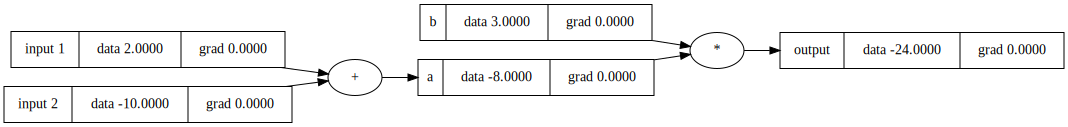

In [9]:
# Lets initialice our graph with default gradients
input_1 = Value(data=2.00, label="input 1")
input_2 = Value(data=-10.00, label="input 2")
a = input_1+input_2
a.label = "a"
b = Value(data=3.00, label="b")
output = a * b 
output.label="output"
draw_dot(output)

First case is simple:
$$\frac{dout}{da} = \frac{d(a*b)}{da} = b$$

Same thing for b:
$$\frac{dout}{db} = \frac{d(a*b)}{db} = a$$


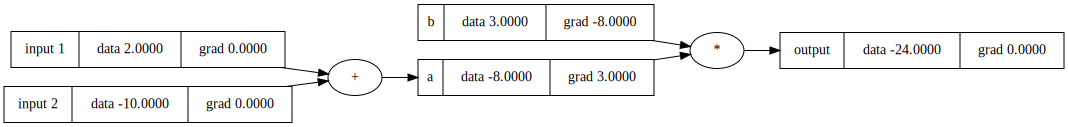

In [10]:
a.grad = b.data
b.grad = a.data
draw_dot(output)

Second node, we have to apply the chain rule:
$$\frac{dout}{din1} = \frac{dout}{da}*\frac{da}{din1} = b*\frac{d(in1+in2)}{din1}=b*1$$

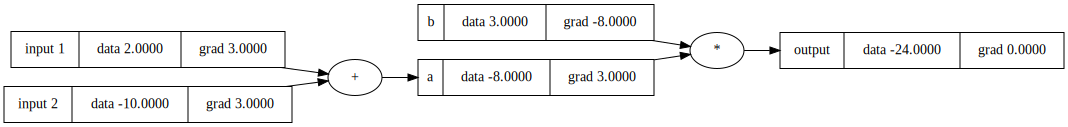

In [11]:
input_1.grad = b.data
input_2.grad = b.data
draw_dot(output)

The next step will be to dive into a single Neuron schema.

A neuron in a neural network receives multiple inputs, each associated with a weight $w_{k1} ,w_{k2} , …$ along with a bias term $b$. It first computes a weighted sum of the inputs and the bias, combining them linearly. After this, the neuron applies an activation function, which introduces non-linearity into the system. This non-linearity is crucial, as it allows the network to learn and model more complex patterns beyond simple linear relationships.

![My Image](../resources/neuron_schema.png "Image Description")


As the activation function, we will be using the hyperbolic tangent, which equals to:

$$\text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$


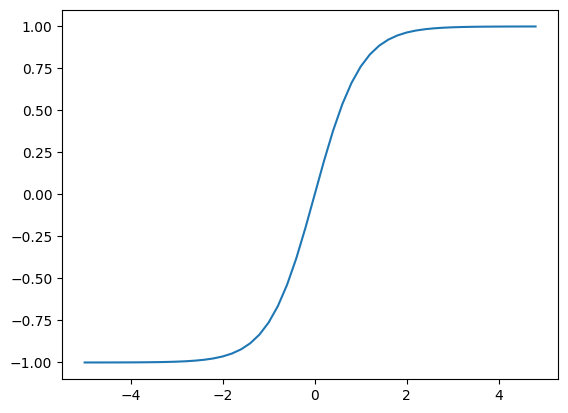

In [12]:
# Lets plot the tanh function
xs = np.arange(-5, 5, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)

In [13]:
# Lets introduce a neuron like architecture

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

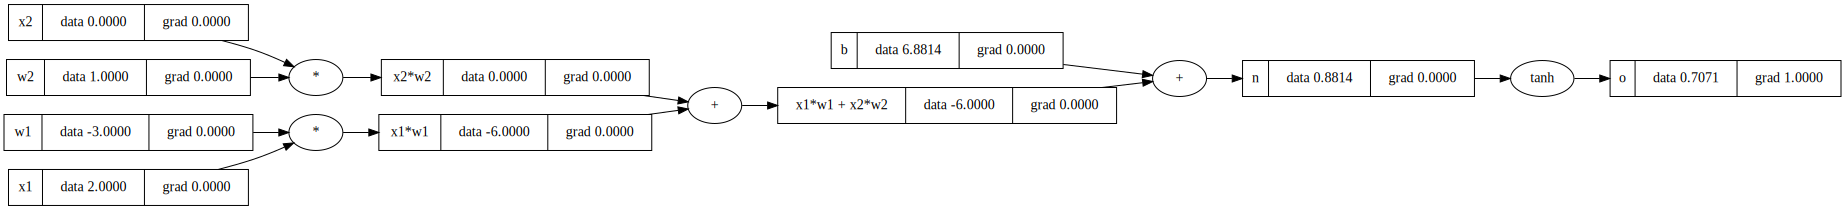

In [14]:
o.grad = 1.00
draw_dot(o)

In [15]:
# Computing every gradient manually is time consuming, so lets create a backward function for our class
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # Gradient initialized to 0
        self._backward = lambda: None  # Backward function, default is a no-op
        self._prev = set(_children)  # Set of parent nodes (to track dependencies)
        self._op = _op  # Operation label
        self.label = label  # Optional label for the value 

    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Helper to ensure operands are of Value type
    def _ensure_value(self, other):
        return other if isinstance(other, Value) else Value(other)

    # Addition
    def __add__(self, other):
        other = self._ensure_value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # f = x + y, df/dx = 1, df/dy = 1
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    # Subtraction
    def __sub__(self, other):
        other = self._ensure_value(other)
        out = Value(self.data - other.data, (self, other), '-')
        
        def _backward():
            # f = x - y, df/dx = 1, df/dy = -1
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        
        return out

    def __rsub__(self, other):
        return Value(other) - self

    # Multiplication
    def __mul__(self, other):
        other = self._ensure_value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # f = x * y, df/dx = y, df/dy = x
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        return self * other

    # Division
    def __truediv__(self, other):
        other = self._ensure_value(other)
        if other.data == 0:
            raise ZeroDivisionError("Cannot divide by zero")
        out = Value(self.data / other.data, (self, other), '/')
        
        def _backward():
            # f = x / y, df/dx = 1/y, df/dy = -x/(y^2)
            self.grad += (1 / other.data) * out.grad
            other.grad += (-self.data / (other.data ** 2)) * out.grad
        out._backward = _backward
        
        return out

    def __rtruediv__(self, other):
        return Value(other) / self

    # Exponentiation
    def __pow__(self, other):
        other = self._ensure_value(other)
        out = Value(self.data ** other.data, (self, other), '**')
        
        def _backward():
            # f = x^y, df/dx = y * x^(y-1), 
            self.grad += (other.data * (self.data ** (other.data - 1))) * out.grad
        out._backward = _backward
        
        return out

    def __rpow__(self, other):
        return Value(other) ** self

    # Hyperbolic Tangent (Tanh)
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            # f = tanh(x), df/dx = 1 - tanh^2(x)
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out

    # e to the power of x (e**x)
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            # f = e**x, df/dx = e**x
            self.grad += out.data * out.grad 
        out._backward = _backward
    
        return out
    # Backpropagation (backward pass)
    def backward(self):
        """
        Ensures that when the backward pass occurs, we process each node only 
        after all the nodes it depends on have been processed.
        """
        topo = []  # List to hold nodes in topologically sorted order
        visited = set()  # Set to track visited nodes
        
        # Topological sort helper
        def build_topo(v):
            if v not in visited:
                visited.add(v) # If not previously visited, add it to the set
                for child in v._prev: # Look theyr children to see if visited
                    build_topo(child)
                topo.append(v) # After the children are processed, we add the node to the list
        
        build_topo(self)  # Start topological sort from the output node
        
        # Set the gradient of the final output to 1 (because dL/dL = 1)
        self.grad = 1.0
        
        # Traverse the graph in reverse topological order and apply chain rule
        for v in reversed(topo):
            v._backward()

In [16]:
# Lets try our redefined class and the backward method
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1
o.backward()

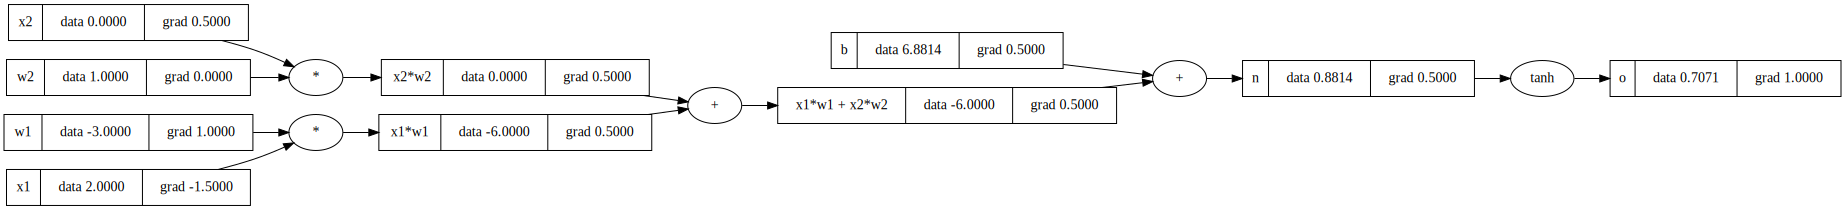

In [17]:
draw_dot(o)

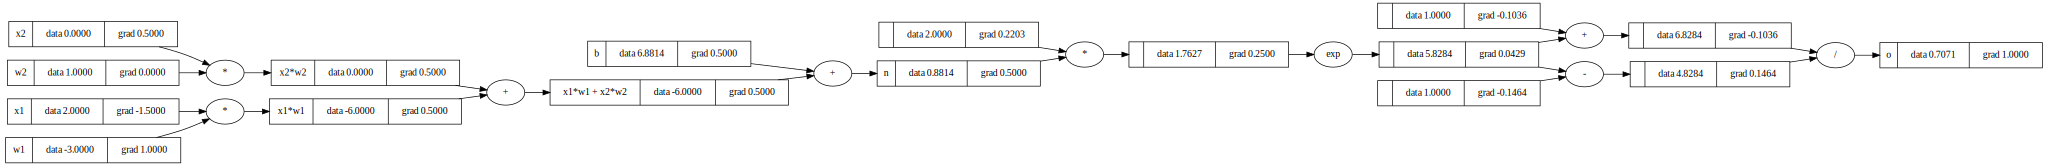

In [18]:
# Instead of using directly tanh, we can decompose it, and backpropagation will work aswell
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

We will now compare our work witha pre-stablished framework like PyTorch.

- PyTorch leverages a core data structure called Tensor.
- A Tensor represents a multi-dimensional array, similar to a NumPy array, but with additional functionality that makes it particularly useful for deep learning tasks.

- The term Tensor is equally defined in mathemathics. Being:
    - 0D Tensor: A scalar (single number).
    - 1D Tensor: A vector (array of numbers).
    - 2D Tensor: A matrix (table of numbers).
    - 3D and higher dimensions: a matrix of matrixs.

- One of the key features of `torch.Tensor` is its ability to automatically compute gradients during backpropagation. This is enabled by PyTorch's autograd system. When `requires_grad=True` is set for a tensor, PyTorch will track all operations on that tensor and automatically compute gradients during the backward pass.

- PyTorch uses a dynamic computation graph (also called define-by-run). This means that the graph is built as you perform operations on the tensors, and the backward pass is calculated based on the operations recorded at runtime. This allows for more flexibility in designing and modifying models compared to static graph frameworks.

In [19]:
import torch

In [20]:
# Instead of using Values, we will be using torch Tensors
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()

x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


A Multi-Layer Perceptron (MLP) is a type of artificial neural network composed of an input layer, one or more hidden layers, and an output layer. Each layer consists of interconnected neurons.

In [21]:
import random

# Lets build a MLP and its components: Neurons and Layers of Neurons.
class Neuron:
  """
  A single neuron in a neural network.
  """
  
  def __init__(self, nin):
    """
    Initializes a neuron with 'nin' inputs.
    """
    # Range between -1 and 1
    self.weights = [Value(random.uniform(-1,1)) for _ in range(nin)] 
    self.bias = Value(random.uniform(-1,1))
    
  def __call__(self, x):
    """
    Computes the output of the neuron given an input 'x'.
    
    n = w1 * x1 + w2 * x2 + ... + b
    tanh(n)
    """
    act = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias)
    out = act.tanh()
    return out
  
  def parameters(self):
    """ 
    Returns a list of the neuron's weights and bias
    """
    return self.weights + [self.bias]

class Layer:
  """
  A layer of neurons in a neural network.
  """
  def __init__(self, nin, nout):
    """
    Initializes the layer with 'nin' inputs for each neuron and 'nout' outputs.
    As every neuron has a single output, 'nout' equeals to the numner of neurons of the layer.
    """
    self.neurons = [Neuron(nin) for _ in range(nout)] # List of initialiced nout neurons

  def __call__(self, x):
    """
    Computes the output of each neuron in the layer given an input 'x'.
    """
    outs = [n(x) for n in self.neurons] # Pass the same inputs to every neuron of the layer
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    """
    Returns a list of the layer's neurons' weights and biases.
    """
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
  """
  A multi-layer perceptron (MLP) neural network.
  """
  
  def __init__(self, nin, nouts):
    """
    Initializes the network with 'nin' inputs and 'nouts' outputs.

    sz contains the number of neurons in each layer (including the input and all hidden and output layers).
    For example, if nin = 3 and nouts = [5, 2], sz becomes [3, 5, 2]

    The number of layers will be len(nouts), the number of inputs of the layer equal to sz[i], and the number of neurons
    per layer equal to sz[i+1].
    For example, if sz is [3, 5, 2] we will have 2 layers, first one 3 in and 5 neurons and the second one, 5 inputs and 2 neurons.
    """
    sz = [nin] + nouts 
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    """
     Computes the output of each layer in the network given an input 'x'.
    """
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    """
    Returns a list of the network's layers' neurons' weights and biases.
    """
    return [p for layer in self.layers for p in layer.parameters()]

In [22]:
# Lets test our MLP
x = [4.0, 1.0, -2.0] # 3 Random inputs
n = MLP(3, [3, 5, 1]) # 3 layers of 3, 5 and 1 neurons
n(x) # Compute the output of our MLP

Value(data=-0.9862091347823237)

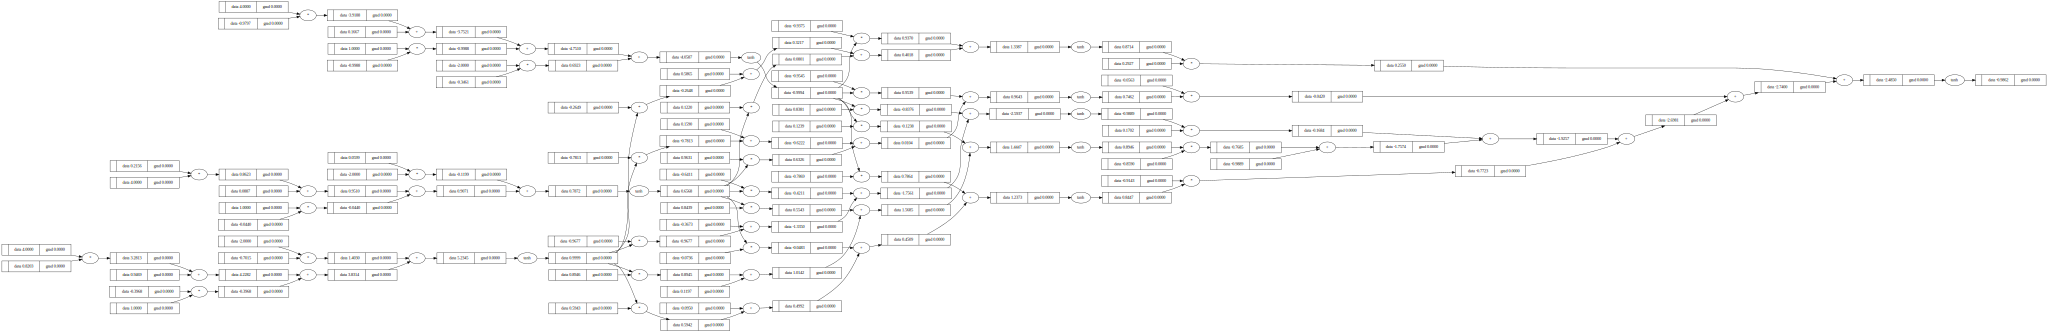

In [23]:
# Lets visualice our MLP
draw_dot(n(x))

The next step is to train our MLP to solve a specific task. To do this, we will use a set of target numerical values that the MLP will attempt to approximate. 

We will input data into the network, and the MLP will produce an output. The difference between the predicted output and the **ground truth** from the dataset is measured using a **loss function**. This loss function quantifies the error. 

Once the loss is calculated, **backpropagation** is used to compute the gradients of the loss with respect to every weight and bias in the network, which are then updated using an optimization algorithm. The most common optimization technique is Stochastic Gradient Descent (SGD).

- In simple terms, we calculate a single number that measures the performance of our neural network (NN), and we call it the loss. In the beginning, the loss will be high (since the NN is not trained), so we will try to minimize it. To achieve this, we use backpropagation, which helps the network understand which parts (weights and biases) are causing the errors. Then, we apply an optimization algorithm to adjust these weights and biases in the right direction. Each time we make these adjustments, the network's predictions get closer to the target values, and the loss decreases.

To quantify the performance of our MLP, we will be using the Mean Square Error.
MSE calculates the average of the squared differences between the predicted values ($\hat{y}$) and the actual target values ($y$). The goal in minimizing MSE is to reduce the magnitude of these differences, which penalizes larger errors more heavily due to the squaring.

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Where: 
- $n$ is the number of data points,
- $y_i$​ is the actual value for the i-th data point and, ​ 
- $\hat{y}_i$ is the predicted value for the 𝑖 i-th data point.


In [24]:
# Lets create a sample dataset with inputs and target values
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [25]:
# Lets code the MSE
ypred = [n(x) for x in xs] # Forward pass for the inputs

mse = sum((yout - ygt)**2 for yout, ygt in zip(ys, ypred)) # just one datas point

In [26]:
# Lets compute a backward pass, updating for the loss
mse.backward()

In [27]:
# Lets see what happened
n.layers[0].neurons[0].weights[0].grad

0.005937430461928298

To optimize the loss function, we will implement a straightforward approach using Gradient Descent. Intuitively, the gradient can be thought of as a vector that points in the direction of increasing loss. Since our goal is to minimize the loss, we need to move in the opposite direction of the gradient.

To achieve this, we will make small adjustments to the weights in the direction opposite to the gradient. By iteratively updating the weights based on randomly selected samples from the dataset, we can effectively reduce the loss over time. This process allows us to progressively approach the minimum possible loss.

The parameters are updated using the following formula: 

$$\theta = \theta - \eta \nabla J(\theta)$$

Where: 
- $\theta$ represents the model parameters (weights and biases). 
- $\eta$ is the learning rate, a hyperparameter that determines the step size of the update.  
- $\nabla J(\theta)$ is the gradient of the loss function $J$.

In [28]:
# Lets wrap up everything, training our MLP by doing 20 forward and backward passes
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # grads add up, so they never reset, so we have to manually do it for every backward pass
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad # Gradient descent, where -0.1 is a step in the opposite direction of the gradient
  
  print(k, loss.data)

0 7.86780040973815
1 7.827873417923943
2 7.75782593070979
3 7.609468169060261
4 7.160465912730173
5 4.866897027055846
6 4.834912846839366
7 4.775719531039647
8 3.6394730846899455
9 0.40050896927800994
10 0.15441832602966551
11 0.10290754205424048
12 0.0817725785766353
13 0.0678772522782779
14 0.058003260428140066
15 0.050617966970915654
16 0.0448838059488168
17 0.04030233252538705
18 0.036557824723113315
19 0.03344039010442196


In [31]:
# As we see, we got close to the desired output
ypred, ys

([Value(data=0.9118993256233046),
  Value(data=-0.9412901308949649),
  Value(data=-0.8893764672545479),
  Value(data=0.9000287713820673)],
 [1.0, -1.0, -1.0, 1.0])